<a href="https://colab.research.google.com/github/Fer071989/loopstructural_intrusions_gmd_paper2023/blob/main/CS2%20-%20Voiseys%20Bay%20Intrusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fer071989/loopstructural_intrusions_gmd_paper2023.git
    !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.1
    !pip install lavavu

else:
    print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


# Case Study 2 - Voisey's Bay Intrusion, Labrador, Canada
- Data from Saumur and Cruden (2015) - On the emplacement of the Voisey’s Bay intrusion (Labrador, Canada)
- Roof data picked at random points on the geological map, and floor data picked from drill holes in cross-sections

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loop library
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer 
# from LoopStructural.modelling.intrusions import ellipse_function, parallelepiped_function

In [3]:
from datetime import datetime

In [4]:
lower_extent = [554800.0,6239650,-3000]
upper_extent = [561000,6243500,500]

## 1. Load data

### Input DataFrame description
> feature_name = name of the geological feature to be modelled. 

> (X, Y, Z) = data points location

> coord = structural frame coordinate

> val = values of the scalar field for interpolation of geological features

> (gx, gy, gz) = gradients of structural frame scalar fields

> intrusion_contact_type = roof/top or floor/base

> intrusion_side = TRUE if lateral contact, blank if not


In [5]:
if 'google.colab' in str(get_ipython()):
    model_data = pd.read_csv('./loopstructural_intrusions_gmd_paper2023/Voiseys Bay Intrusion.csv')
else:
    model_data = pd.read_csv('Voiseys Bay Intrusion.csv')

intrusion_data = model_data[model_data['feature_name'] == 'Voiseys Bay Intrusion'].copy()
model_data.head()

,feature_name,X,Y,Z,coord,val,gx,gy,gz,intrusion_contact_type,intrusion_side
0,stratigraphy,555000.0,6243500.0,0.0,NaN,1000.0,NaN,NaN,NaN,NaN,NaN
1,stratigraphy,555000.0,6240500.0,0.0,NaN,1000.0,NaN,NaN,NaN,NaN,NaN
2,stratigraphy,555000.0,6243500.0,-500.0,NaN,500.0,NaN,NaN,NaN,NaN,NaN
3,stratigraphy,555000.0,6240500.0,-500.0,NaN,500.0,NaN,NaN,NaN,NaN,NaN
4,stratigraphy,555000.0,6243500.0,-1000.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


## 2. Geological model

### The ``create_and_add_intrusion`` function of the ``GeologicalModel`` class creates an ``IntrusionFeature`` in two steps: 

### Step 1 - Create the intrusion frame using the ``IntrusionFrameBuilder`` class:

IntrusionFrameBuilder creates the intrusion structural frame.
This object is a curvilinear coordinate system of the intrusion body, and it has three coordinates:
> coordinate 0: it represents an approximate location of the roof or floor contact of the intrusion, and its gradient representes the growth or inflation of the magma. It is constrained using data from either the roof or floor contact. If no inflation data is available, it is assumed that the gradient of this coordinate is perpendicular to the stratigraphy.

> coordinate 1: it represents the flow direction of the intrusion. Its gradient is parallel to the propagation of the magma, which can be constrained with flow direction measurements (e.g., AMS data). In this example, we only have contact data point, so we assume the propagation was parallel to the long axis of the intrusion. 

> coordinate 2: it is parallel to the long axis of the intrusion. 

The extent of the intrusion is defined as distances along the axes of the intrusion frame.

In [6]:
intrusion_frame_data = model_data[model_data['feature_name'] == 'Voiseys Bay Intrusion Frame'].copy()
intrusion_frame_data

,feature_name,X,Y,Z,coord,val,gx,gy,gz,intrusion_contact_type,intrusion_side
87,Voiseys Bay Intrusion Frame,558534.480,6240720.703,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
88,Voiseys Bay Intrusion Frame,556397.421,6242578.301,0.0,1.0,NaN,-0.56,0.83,0.0,NaN,NaN
89,Voiseys Bay Intrusion Frame,557572.804,6241550.868,0.0,1.0,NaN,-0.85,0.53,0.0,NaN,NaN
90,Voiseys Bay Intrusion Frame,558534.480,6240720.703,0.0,1.0,NaN,-0.85,0.53,0.0,NaN,NaN
91,Voiseys Bay Intrusion Frame,556397.421,6242578.301,0.0,2.0,0.0,NaN,NaN,NaN,axis,NaN
92,Voiseys Bay Intrusion Frame,557572.804,6241550.868,0.0,2.0,0.0,NaN,NaN,NaN,axis,NaN
93,Voiseys Bay Intrusion Frame,558534.480,6240720.703,0.0,2.0,0.0,NaN,NaN,NaN,axis,NaN
94,Voiseys Bay Intrusion Frame,555696.073,6243226.362,0.0,2.0,0.0,NaN,NaN,NaN,axis,NaN
95,Voiseys Bay Intrusion Frame,556397.421,6242578.301,0.0,2.0,NaN,0.81,0.59,0.0,axis,NaN
96,Voiseys Bay Intrusion Frame,557572.804,6241550.868,0.0,2.0,NaN,0.53,0.85,0.0,axis,NaN


### Step 2 - Compute threshold distances to constrain the intrusion extent, using the ``IntrusionBuilder`` class:

The IntrusionBuilder computes thresholds distances (along the structural frame coordinates) to constrain the intrusion lateral and vertical extent.

Distances along the axis of coordinate 2 are computed to constraint the intrusion lateral extent, and distances along the axis of coordinate 0 are computed to constained its vertical extent. 

Thresholds values are restricted using conceptual geometrical models representing the expected shape of the intrusion.


#### Conceptual model function to constraint lateral and vertical extent

These conceptual model are used to define the geometry of the intrusion contact where there is no data available.

They allow the modeler to integrate their interpretation of the intrusion geometry.

Considering the spatial distribution of the data, we will use an *ellipsis* to constrain it lateral extent. 
And, we will test two geometries for the floor contac: an *oblique cone* to represent a wedge-shaped geometry, and a *constant thickness* to represent a tablet-shaped geometry 

In [7]:
# Conceptual models

def ellipse_function(
    lateral_contact_data = pd.DataFrame() , model = False, minP=None, maxP=None, minS=None, maxS=None
):
    
    if lateral_contact_data.empty:
        return model, minP, maxP, minS, maxS
    else:
        if minP == None:
            minP = lateral_contact_data["coord1"].min()
        if maxP == None:
            maxP = lateral_contact_data["coord1"].max()
        if minS == None:
            minS = lateral_contact_data["coord2"].abs().min()
        if maxS == None:
            maxS = lateral_contact_data["coord2"].max()

        a = (maxP - minP) / 2
        b = (maxS - minS) / 2

        po = minP + (maxP - minP) / 2

        p_locations = lateral_contact_data.loc[:, "coord1"].copy().to_numpy()

        s = np.zeros([len(p_locations), 2])

        s[np.logical_and(p_locations>minP, p_locations<maxP),0] =  b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 
        s[np.logical_and(p_locations>minP, p_locations<maxP),1] =  -b * np.sqrt(1 - np.power((p_locations[np.logical_and(p_locations>minP, p_locations<maxP)] - po) / a, 2)) 

        return s

def obliquecone_function(othercontact_data = pd.DataFrame(), 
                         mean_growth=None, minP=None, maxP=None, minS=None, maxS=None, vertex=None): 
    # import math
    
    if othercontact_data.empty:
        return mean_growth
    
    ps_locations = othercontact_data.loc[:,['coord1','coord2']].to_numpy()
    
    minP=1.5*minP
    maxP=1.5*maxP 
    minS=1.5*minS
    maxS=1.5*maxS
    
    a = (maxP-minP)/2 #semi-major axis
    b = (maxS-minS)/2 #semi-minor axis
    a2 = pow(a,2)
    b2 = pow(b,2)
    
    po = minP + a #p coordinate of ellipsis centre
    so = minS + b #s coordinate of ellipsis centre
    
    alpha = vertex[0] #p coordinate of vertex
    beta = vertex[2] #g coordinate of vertex
    gamma = vertex[1] #l coordinate of vertex
    
    growth = np.zeros([len(ps_locations),2]) #container for results
    
    p = ps_locations[:,0]
    s = ps_locations[:,1]
        
    A = alpha - po
    B = beta*(p[:] - alpha)
    C = gamma - so
    D = beta*(s[:] - gamma)
        
    F = pow(A*b,2) + pow(C*a,2) - a2*b2
    G = 2*(B*A*b2 + C*D*a2)
    H = pow(b*B,2) + pow(a*D,2)
        
    constant_g2 = F
    constant_g = -2*F*beta - G
    constant_1 = F*pow(beta,2) + G*beta + H
        
    discriminant = pow(constant_g,2) - 4*constant_g2*constant_1
    discriminant[discriminant < 0] = 0

    growth[:,0] = -(constant_g + np.sqrt(discriminant))/(2*constant_g2)
    growth[:,1] = -(constant_g - np.sqrt(discriminant))/(2*constant_g2)
        
    return growth

def thickness_constant_vertex(othercontact_data = pd.DataFrame(), 
                              mean_growth=None, minP=None, maxP=None, minS=None, maxS=None, vertex=None): 
    # import math
    if othercontact_data.empty:
        return mean_growth
    
    ps_locations = othercontact_data.loc[:,['coord1','coord2']].to_numpy()
    
    minP=1.5*minP
    maxP=1.5*maxP 
    minS=1.5*minS
    maxS=1.5*maxS
    
    a = (maxP-minP)/2 #semi-major axis
    b = (maxS-minS)/2 #semi-minor axis
    a2 = pow(a,2)
    b2 = pow(b,2)
    
    po = minP + a #p coordinate of ellipsis centre
    so = minS + b #s coordinate of ellipsis centre
    
    alpha = vertex[0] #p coordinate of vertex
    beta = vertex[2] #g coordinate of vertex
    gamma = vertex[1] #l coordinate of vertex
    
    growth = np.zeros([len(ps_locations),2]) #container for results
    

    growth[:,0] = alpha
    growth[:,1] = alpha
        
    return growth

## Create the 3D geological model.

First, we build the host rock (conformable stratigraphy), and then we build the intrusion, whose geometry is controlled by the host rock geometry. 

In [8]:
model = GeologicalModel(lower_extent,upper_extent)
model.nsteps = [30,30,30]
model.data = model_data

conformable_feature = model.create_and_add_foliation('stratigraphy', nelements = 3000, solver = 'lu', interpolatortype = 'FDI')

Cannot use region
Cannot use region


In [9]:
viewer_data = LavaVuModelViewer(model, background='white')
viewer_data.add_isosurface(conformable_feature, nslices = 6, paint_with = conformable_feature)

viewer_data.add_points(intrusion_data.loc[:,['X','Y','Z']].to_numpy(), name = 'intrusion data', pointsize = 10)

viewer_data.rotate([-86.563, -10.394, -0.255])
viewer_data.interactive()

In [10]:
intrusion_frame_parameters = {'type' : 'interpolated',
                              'contact' :'roof', # reference contact to buil coordinate 0 of the intrusion frame
                              'contact_anisotropies':[conformable_feature] # host rock controlling the intrusion geometry
                             }

vertical_conceptual_model = obliquecone_function   #change to 'parallelepiped_function'

print(datetime.now().isoformat(timespec='seconds'))   

VoiseysBay_Intrusion_Wedge = model.create_and_add_intrusion('Voiseys Bay Intrusion', intrusion_frame_name = 'Voiseys Bay Intrusion Frame',
                                                            intrusion_frame_parameters = intrusion_frame_parameters,
                                                            intrusion_lateral_extent_model = ellipse_function,
                                                            intrusion_vertical_extent_model = vertical_conceptual_model,
                                                            interpolatortype = 'FDI'
                                                           )
print(datetime.now().isoformat(timespec='seconds'))

vertical_conceptual_model = thickness_constant_vertex
VoiseysBay_Intrusion_Tablet = model.create_and_add_intrusion('Voiseys Bay Intrusion', intrusion_frame_name = 'Voiseys Bay Intrusion Frame',
                                                             intrusion_frame_parameters = intrusion_frame_parameters,
                                                             intrusion_lateral_extent_model = ellipse_function,
                                                             intrusion_vertical_extent_model = vertical_conceptual_model,
                                                             interpolatortype = 'FDI'
                                                            )
print(datetime.now().isoformat(timespec='seconds'))  

2023-09-23T11:03:48
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
2023-09-23T11:03:49
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
2023-09-23T11:03:49


## 3. Visualisation of 3D Geological Model

In [11]:
nn = 50 # improve model resolution by changing this value
model.nsteps = [nn,nn,nn]

In [12]:
datetime.now().isoformat(timespec='seconds')   

'2023-09-23T11:03:49'

In [13]:
viewer = LavaVuModelViewer(model, background='white')

# add host rock
# viewer.add_isosurface(conformable_feature['feature'], nslices = 3, colour = 'grey')

# add intrusion data and intrusion contact isosurface
viewer.add_points(intrusion_data.loc[:,['X','Y','Z']].to_numpy(), name = 'intrusion data', pointsize = 20)
viewer.add_isosurface(VoiseysBay_Intrusion_Wedge, isovalue = 0, colour = 'red', name = 'Model with conic shape')
viewer.add_isosurface(VoiseysBay_Intrusion_Tablet, isovalue = 0, colour = 'pink', name = 'Model with tablet shape')
# viewer.add_scalar_field(VoiseysBay_Intrusion_Wedge)
# viewer.add_section(y = 0.6, paint_with = VoiseysBay_Intrusion)

viewer.xmin = 0 
viewer.xmax = 1 
viewer.ymin = 0 
viewer.ymax = 1 

viewer.rotate([-86.563, -10.394, -0.255])
viewer.interactive()

In [14]:
datetime.now().isoformat(timespec='seconds')   

'2023-09-23T11:04:26'

## 4. Visualisation of intrusion frame

In [15]:
intrusion_frame = VoiseysBay_Intrusion_Wedge.intrusion_frame
roof_data = intrusion_data[intrusion_data['intrusion_contact_type'] == 'roof'].loc[:,['X','Y','Z',]].to_numpy()

In [16]:
viewer_frame = LavaVuModelViewer(model, background='white')

viewer_frame.add_isosurface(intrusion_frame[0], isovalue =0, colour = 'darkred')
viewer_frame.add_isosurface(intrusion_frame[1], isovalue =0, colour = 'darkgreen')
viewer_frame.add_isosurface(intrusion_frame[2], isovalue = 0, colour = 'blue')
# viewer_frame.add_data(intrusion_frame[0])
# viewer_frame.add_points(roof_data, name = 'roof data', pointsize = 10)
# viewer_frame.add_data(intrusion_frame[0])
# viewer_frame.add_data(intrusion_frame[1])
# viewer_frame.add_data(intrusion_frame[2])

viewer_frame.rotate([-86.563, -10.394, -0.255])
viewer_frame.interactive()

In [17]:
# VoiseysBay_Intrusion_Wedge.intrusion_frame.builder[0].interpolator

### 5. Check conditioning of the models

(array([ 2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3., 67.]),
 array([-1.15278453e-10, -1.03488063e-10, -9.16976717e-11, -7.99072808e-11,
        -6.81168899e-11, -5.63264990e-11, -4.45361081e-11, -3.27457172e-11,
        -2.09553264e-11, -9.16493548e-12,  2.62545541e-12]),
 <BarContainer object of 10 artists>)

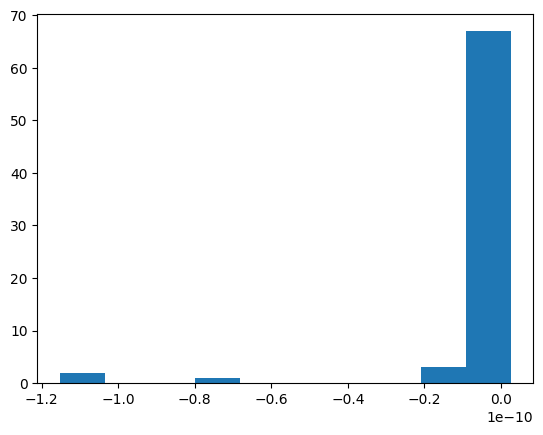

In [18]:
intrusion = VoiseysBay_Intrusion_Tablet
intrusion_data = intrusion_data
intrusion_data_xyz = intrusion_data.loc[:,['X','Y','Z',]].to_numpy()
sf_array = intrusion.evaluate_value(model.scale(intrusion_data_xyz, inplace=False))

import matplotlib.pyplot as plt
plt.hist(sf_array) #, bins='auto')

### 6. Visualize Lateral conceptual model

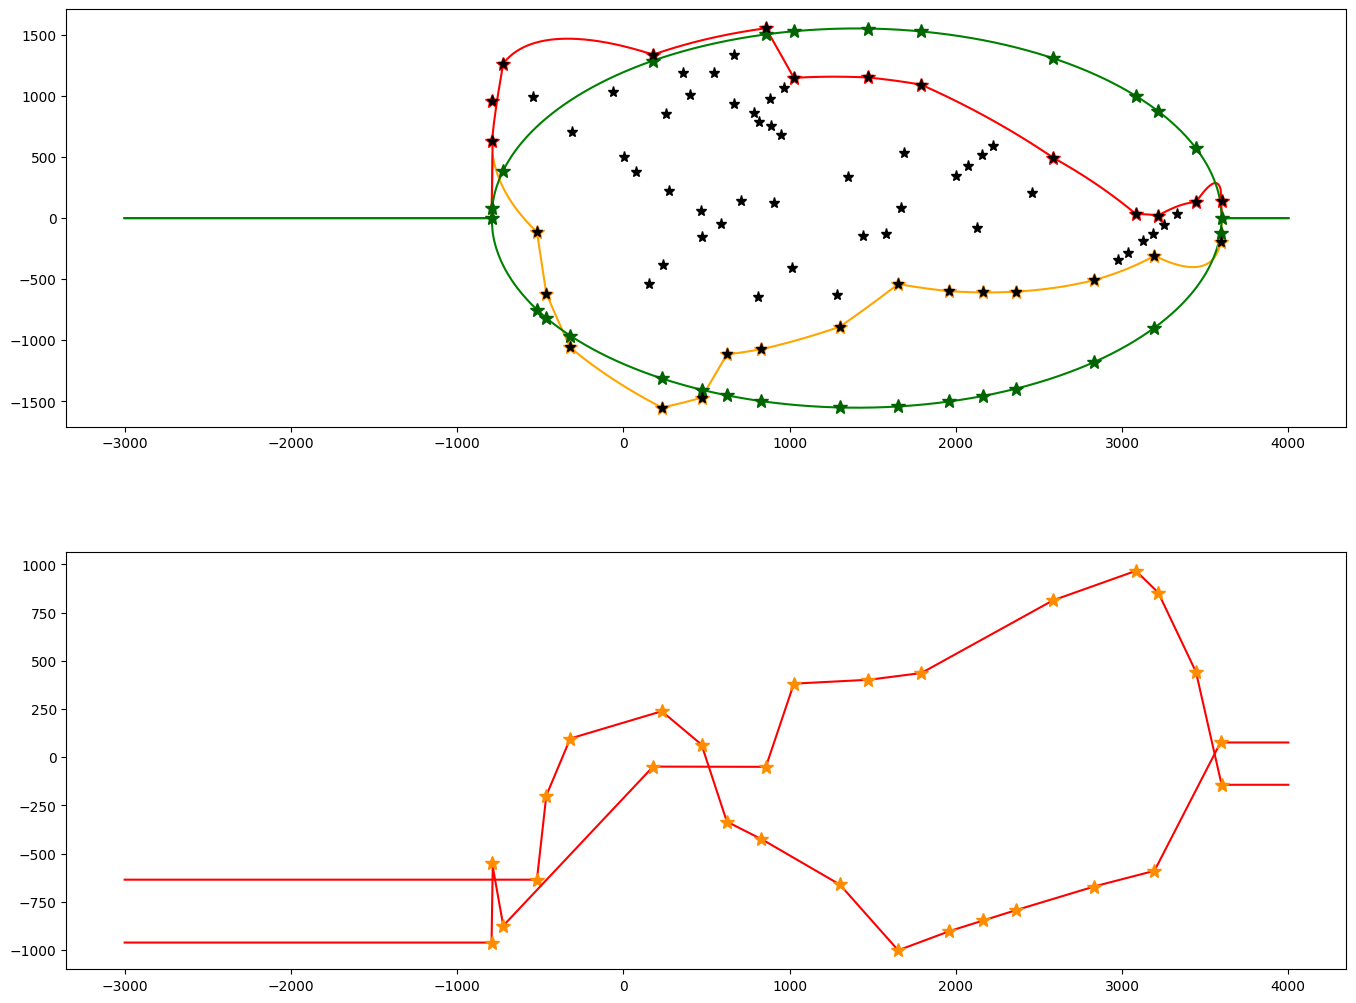

In [19]:
Intrusion = VoiseysBay_Intrusion_Tablet
coordinate1 = np.linspace(-3000,4000,1000)

lateral_data = Intrusion.builder.data_for_lateral_extent_calculation
vertical_data = Intrusion.builder.data_for_vertical_extent_calculation
threshold_values, residual_values, conceptual_values = Intrusion.interpolate_lateral_thresholds(coordinate1)

plt.subplot(211) # Lateral extent simulated values and data     
plt.plot(coordinate1, threshold_values[0],"-",c='orange', markersize = 10)
plt.plot(coordinate1, conceptual_values[0],"-",c='green', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'coord2'],"*", c='darkorange', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)
plt.plot(coordinate1,threshold_values[1],"-",c='red', markersize = 10)
plt.plot(coordinate1,conceptual_values[1],"-",c='green', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'coord2'],"*", c='red', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_conceptual'],"*", c='darkgreen', markersize = 10)
plt.plot(vertical_data[0].loc[:,'coord1'],vertical_data[0].loc[:,'coord2'],"*", c='black', markersize = 8)
plt.plot(vertical_data[1].loc[:,'coord1'],vertical_data[1].loc[:,'coord2'],"*", c='black', markersize = 8)

plt.subplot(212) # Lateral extent simulated values and data     
plt.plot(coordinate1,residual_values[0],"-",c='red', markersize = 10)
plt.plot(lateral_data[0].loc[:,'coord1'],lateral_data[0].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)
plt.plot(coordinate1,residual_values[1],"-",c='red', markersize = 10)
plt.plot(lateral_data[1].loc[:,'coord1'],lateral_data[1].loc[:,'l_residual'],"*", c='darkorange', markersize = 10)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=2, wspace=0.2, hspace=0.3)
plt.show()